In [2]:
import os
import sys
import numpy as np
import torch
import torchvision
import pickle

sys.path.insert(0, '../fl')
data_path = '../data'

In [5]:
def partition_data(dataset, n_clients=3, random_seed=1, alpha=0.1):
    y_s = torch.tensor([dataset.__getitem__(i)[1] for i in range(len(dataset))])

    labels = torch.unique(y_s)
    n_classes = len(labels)

    np.random.seed(random_seed)
    dist = np.random.dirichlet(np.ones(n_clients) * alpha, n_classes)

    labels_ind = {
        j: [] for j in range(n_classes)
    }

    labels_map = {
        label.item(): j for j, label in enumerate(labels)
    }

    for i, y in enumerate(y_s):
        labels_ind[labels_map[y.item()]].append(i)
    
    labels_len = np.array([len(labels_ind[j]) for j in range(n_classes)])

    dist = np.cumsum(dist, axis=1) * labels_len.reshape(n_classes, 1)
    dist = dist.astype(int)
    dist = np.concatenate([np.zeros((n_classes, 1), int), dist], axis=1)

    clients_ind = {
        i: [] for i in range(n_clients)
    }

    for i in range(n_clients):
        for j in range(n_classes):
            clients_ind[i].extend(labels_ind[j][dist[j, i]:dist[j, i + 1]])
    return clients_ind
    
    

## Synthetic Data

In [2]:
NUM_USER = 30

def softmax(x):
    ex = np.exp(x)
    sum_ex = np.sum(ex)
    return ex/sum_ex

def generate_synthetic(alpha, beta, iid):

    dimension = 60
    NUM_CLASS = 10
    
    samples_per_user = np.random.lognormal(4, 2, (NUM_USER)).astype(int) + 50
    print(samples_per_user)

    X_split = [[] for _ in range(NUM_USER)]
    y_split = [[] for _ in range(NUM_USER)]


    #### define some eprior ####
    mean_W = np.random.normal(0, alpha, NUM_USER)
    mean_b = mean_W
    B = np.random.normal(0, beta, NUM_USER)
    mean_x = np.zeros((NUM_USER, dimension))

    diagonal = np.zeros(dimension)
    for j in range(dimension):
        diagonal[j] = np.power((j+1), -1.2)
    cov_x = np.diag(diagonal)

    for i in range(NUM_USER):
        if iid == 1:
            mean_x[i] = np.ones(dimension) * B[i]  # all zeros
        else:
            mean_x[i] = np.random.normal(B[i], 1, dimension)
        print(mean_x[i])

    if iid == 1:
        W_global = np.random.normal(0, 1, (dimension, NUM_CLASS))
        b_global = np.random.normal(0, 1,  NUM_CLASS)

    for i in range(NUM_USER):

        W = np.random.normal(mean_W[i], 1, (dimension, NUM_CLASS))
        b = np.random.normal(mean_b[i], 1,  NUM_CLASS)

        if iid == 1:
            W = W_global
            b = b_global

        xx = np.random.multivariate_normal(mean_x[i], cov_x, samples_per_user[i])
        yy = np.zeros(samples_per_user[i])

        for j in range(samples_per_user[i]):
            tmp = np.dot(xx[j], W) + b
            yy[j] = np.argmax(softmax(tmp))

        X_split[i] = xx.tolist()
        y_split[i] = yy.tolist()

        print("{}-th users has {} exampls".format(i, len(y_split[i])))

    y_split = np.concatenate(y_split).astype(int)
    X_split = np.concatenate(X_split).astype(int)


    return X_split, y_split, np.append([0], np.cumsum(samples_per_user))

In [3]:
np.random.seed(123)
a_b_s = [(0., 0.), (0.5, 0.5), (1., 1.)]

for alpha, beta in a_b_s:
    X_s, y_s, n_s_sum = generate_synthetic(alpha, beta, 0)
    synth_name = f'synth_{alpha}_{beta}.npz'
    with open(os.path.join(data_path, synth_name), 'wb') as f:
        np.savez(f, x=X_s, y=y_s, n=n_s_sum)

[  56  451  146   52   67 1534   50   73  736   59   64   95 1127   65
   72   72 4550 4381  456  168  288 1126   58  623   54   65  385   53
   91   59]
[ 1.15020554 -1.26735205  0.18103513  1.17786194 -0.33501076  1.03111446
 -1.08456791 -1.36347154  0.37940061 -0.37917643  0.64205469 -1.97788793
  0.71226464  2.59830393 -0.02462598  0.03414213  0.17954948 -1.86197571
  0.42614664 -1.60540974 -0.4276796   1.24286955 -0.73521696  0.50124899
  1.01273905  0.27874086 -1.37094847 -0.33247528  1.95941134 -2.02504576
 -0.27578601 -0.55210807  0.12074736  0.74821562  1.60869097 -0.27023239
  0.81234133  0.49974014  0.4743473  -0.56392393 -0.99732147 -1.10004311
 -0.75643721  0.32168658  0.76094939  0.32346885 -0.5489551   1.80597011
  1.51886562 -0.35400011 -0.82343141  0.13021495  1.26729865  0.33276498
  0.5565487  -0.21208012  0.4562709   1.54454445 -0.23966878  0.14330773]
[ 0.25381648  0.28372536 -1.41188888 -1.87686866 -1.01965507  0.1679423
  0.55385617 -0.53067456  1.37725748 -0.143

## CIFAR10 - non-iid

In [7]:
trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True)
partition = partition_data(trainset, n_clients=16, random_seed=1, alpha=0.1)
pickle.dump(partition, open( f"{data_path}/cifar10.pkl", "wb" ))
lengths = [len(partition[client]) for client in partition]
print(f"CIFAR10: {np.ceil(np.max(lengths) / 128) / np.ceil(np.min(lengths) / 128)}...{np.min(lengths)}...{np.max(lengths)}...{np.sum(lengths)}...{lengths}")

Files already downloaded and verified
CIFAR10: 32.0...229...8114...49999...[4569, 229, 4823, 4644, 5388, 1500, 265, 8114, 4640, 514, 4341, 431, 3556, 851, 3669, 2465]


In [9]:
from data_funcs.fl_datasets import FLCifar10, FLCifar10Client

fl_dataset = FLCifar10(root=data_path, train=True, download=True,transform=None)
trainsets = [FLCifar10Client(fl_dataset, client_id=client_id)
             for client_id in range(16)]

Files already downloaded and verified


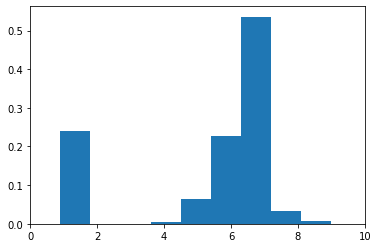

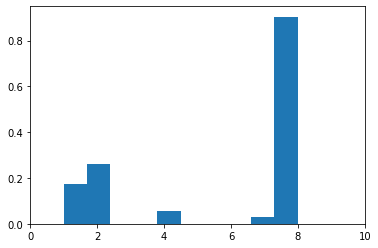

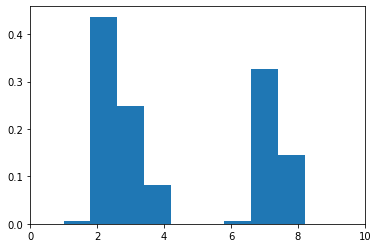

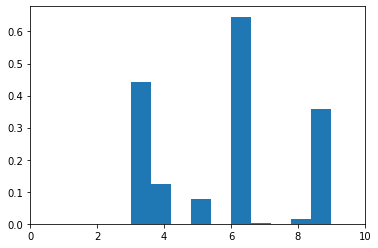

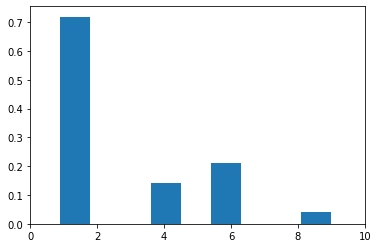

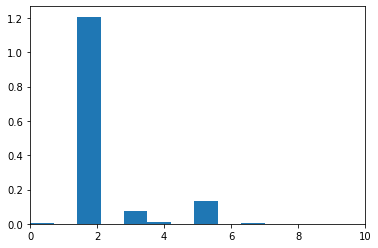

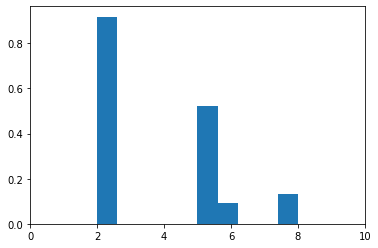

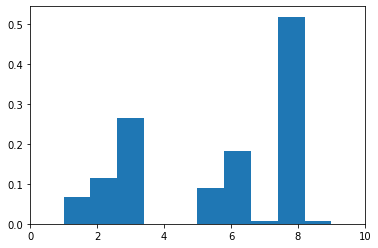

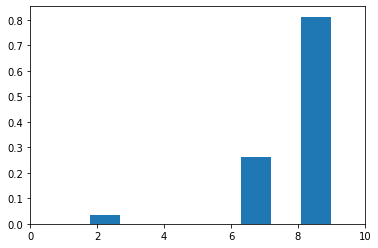

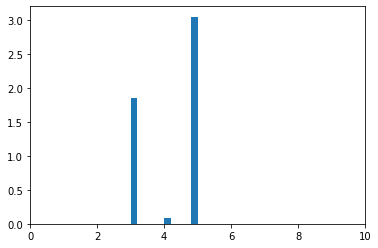

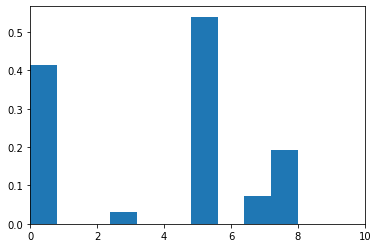

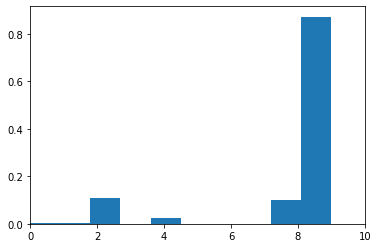

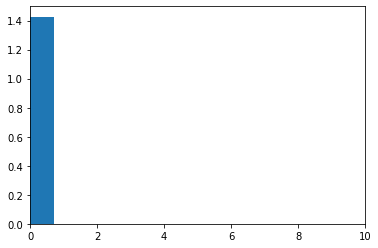

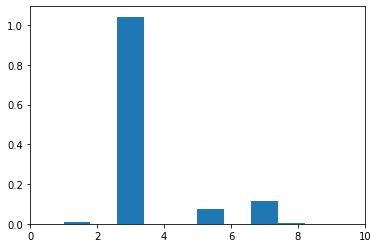

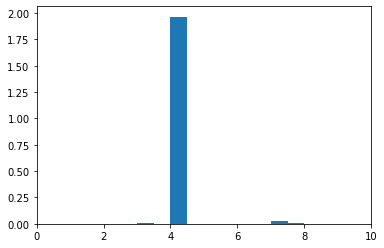

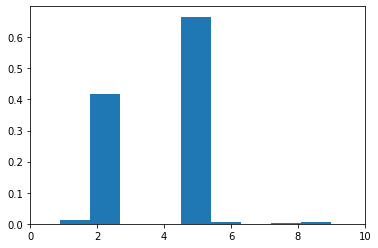

In [12]:
import matplotlib.pyplot as plt

for ts in trainsets:
    y = np.array([ts.__getitem__(i)[1] for i in range(len(ts))])
    plt.hist(y, bins=10, density=True)
    plt.xlim([0, 10])
    plt.show()